<a href="https://colab.research.google.com/github/Angus-Eastell/Intro_to_AI/blob/main/5_2_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backprop [non-examinable]

**This is "formally" non-examinable, but should be super-useful in reinforcing the examinable material in the notes!**

In the notes, we saw the theory of the backprop algorithm.  Now, I'm going to show you how to implement backprop.  There are three key players:
* MyLeafTensor: stores tensors and their gradients (e.g. data and parameters)
* MyFuncTensor:
  - stores the result of applying functions to `MyLeafTensor`s and other `MyFuncTensor`s.  For instance, all the intermediate layer activations are `MyFuncTensor`s.  
  - stores the compute graph by keeping a record of how the tensor is produced (both the function called and the arguments used).
  - Includes the logic for recursing backward through the compute graph in backprop.
* Functions (`Add`, `Mul`, `SqErr`, `Linear`, `ReLU`).  These store the forward and backward functions for each operation.

#### MyLeafTensor

This is a tensor that contains information like data or parameters (i.e. that isn't the result of applying a function to other tensors).

Note that it contains a `.grad` field which accumulates the gradient, and that `.backward(self, delta)` just adds the backpropagating derivative, `delta` to the accumulated gradient.

In [20]:
import numpy as np

class MyLeafTensor:
    """
    This is a pretty simple class.  Its just a "wrapper" for a value: either
    a Python number or Numpy array.

    The only interesting addition is that it also has a .grad field, which stores
    the backpropagating derivatives.  Specifically, any time we get backpropagating
    derivatives in backward, it increments self.grad with them.
    """
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)

    def backward(self, delta):
        self.grad = self.grad + delta

    def zero_grad(self):
        self.grad = np.zeros_like(self.value)

    #Pretty-printing; ignore this as it is Python arcana
    def __str__(self):
        return f"MyLeafTensor({self.value})"
    __repr__ = __str__

#### MyFuncTensor:

This stores the the result of applying functions to `MyLeafTensor`s and other `MyFuncTensor`s.  In `.__init__`:
* `f` is the function used (it'll be an object from one of the classes we define below, like `Add` or `Mul`).
* We store the arguments to the function both as tensors (`MyLeafTensor` or `MyFuncTensor`) and as numpy arrays.  Storing as numpy arrays is useful to actually compute values (e.g. `Add.forward` takes numpy arrays as inputs).  But you need arguments as `MyFuncTensor` / `MyLeafTensor`s to retain the compute graph.  Specifically, some of the arguments to this `MyFuncTensor` are themselves `MyFuncTensor`s which also record the function + arguments used to create them.  Overall, the graph of `MyFuncTensor`s record the full process by which the final result (usually the loss) was produced.
* Includes the "logic" for the backward pass in `MyFuncTensor.backward(delta)`.  Here, `delta=`$\frac{d\mathcal{L}}{d\text{ outputs}}$.  Thus, `MyFuncTensor.backward` starts with `delta=`$\frac{d\mathcal{L}}{d\text{ outputs}}$, then uses e.g. `Add.backward(delta)` or `Mul.backward(delta)` on the stored function to compute $\frac{d\mathcal{L}}{d\text{ inputs}}$.  Critically, the inputs to this function are themselves the outputs from other functions.  Thus, the $\frac{d\mathcal{L}}{d\text{ inputs}}$ are also the $\frac{d\mathcal{L}}{d\text{ outputs}}$ for other functions.  We therefore pass these derivatives into the `.backward(...)` on these other functions.  Recursing this process moves backward through the compute graph, hence "backprop".

In [21]:
class MyFuncTensor:
    """
    MyFuncTensor is more interesting.  This represents a Tensor that is created
    by applying a Function to other MyTensor's.

    This class records the 'compute graph' by remembering the function and
    arguments used to create it.  That allows us to go backwards in backprop
    """
    def __init__(self, f, args):
        #Check the function is one of our special functions
        assert isinstance(f, (Add, Mul, Linear, ReLU, SqErr))
        #Check the arguments are all MyTensors
        assert all(isinstance(arg, (MyLeafTensor, MyFuncTensor)) for arg in args)

        #Record the function and arguments (as MyTensors)
        self.f = f
        self.mytensor_args = args
        #Get the value (e.g. as a numpy array) for each of the arguments.
        self.np_args = [arg.value for arg in args]
        #Compute the result by passing e.g. numpy arrays, _not_ MyTensors into f.forward.
        #the * "splats" arguments: f(*[1,2]) == f(1,2)
        self.value = f.forward(*self.np_args)

    def backward(self, delta):
        """
        This is where the backprop magic happens.

        Takes the backpropagating derivative for the output (delta) as an argument.
        Uses f.backward to compute the backpropagating derivative for the input arguments.
        Calls arg.backward on each of those arguments, with the computed derivative.
        """
        assert not isinstance(delta, tuple)
        #Compute the derivatives for each argument using f.backward,
        #exactly as in the pdf.  Note we're splatting again: f(*[1,2]) == f(1,2)
        #the returned arg_deltas are all e.g. Numpy arrays.
        arg_deltas = self.f.backward(delta, *self.np_args)

        #Check we have the same number of arguments as deltas.
        assert len(self.mytensor_args) == len(arg_deltas)

        #Now we have to make sure that these backpropagating derivatives are
        #given to the mytensor_arg.backward method on each argument tensor.
        for i in range(len(arg_deltas)):
            self.mytensor_args[i].backward(arg_deltas[i])


    #Pretty-printing; ignore this as it is Python arcana
    def __str__(self):
        return f"MyFuncTensor({self.f.__class__.__name__}, {self.mytensor_args})"
    __repr__ = __str__

#### Functions (`Add`, `Mul`, `SqErr`, `Linear`, `ReLU`).

Here, we write each function as a class, so that we can bind together the forward and backward passes for each function.  Note that the backward pass here is only "local" (it only applies to one operation).  The global backward recursion is handled by `MyFuncTensor`.

Note that e.g. `Add.forward` and `Add.backward` take Numpy arrays as inputs, _not_ `MyLeafTensor`s or `MyFuncTensor`s, and they're only called internally, by stuff inside `MyFuncTensor`.

To actually add two `MyFuncTensor`s or `MyLeafTensor`s, we therefore need a little method (e.g. `add`).  This constructs a `MyFuncTensor` representing the application of addition, and takes `MyFuncTensor`s or `MyLeafTensor`s as inputs.

In [22]:
class Add:
    """
    y = a + b
    Will only work if a and b are same sized.
    """
    def forward(self, a, b):
        return a+b

    def backward(self, dy, a, b):
        da = dy
        db = dy
        return (da, db)
#We define simple functions like `add` which construct a MyFuncTensor from
#the arguments and function.
def add(a, b):
    return MyFuncTensor(Add(), (a, b))

class Mul:
    """
    y = a * b
    Will only work if a and b are same sized.
    """
    def forward(self, a, b):
        return a * b

    def backward(self, dy, a, b):
        da = dy*b
        db = dy*a
        return (da, db)
def mul(a, b):
    return MyFuncTensor(Mul(), (a, b))

#We can also implement NNs if we define a couple more functions (we'll play with
#these later)

class Linear:
    def forward(self, h, W, b):
        return h @ W + b

    def backward(self, da, h, W, b):
        dh = (da @ W.T)
        dW = h.T @ da
        db = da.sum(0)
        return (dh, dW, db)
def linear(h, W, b):
    return MyFuncTensor(Linear(), (h, W, b))

class ReLU:
    def forward(self, a):
        return a*(a>0)

    def backward(self, dh, a):
        da = dh*(a>0)
        return (da,)
def relu(a):
    return MyFuncTensor(ReLU(), (a,))

class SqErr:
    def forward(self, y, f):
        return ((y-f)**2).sum()

    def backward(self, dL, y, f):
        dy = dL * (y-f)
        df = dL * (f-y)
        return (dy, df)
def sqerr(f, y):
    return MyFuncTensor(SqErr(), (f, y))

Consider a simple example:
\begin{align}
a &= 2\\
b &= 3\\
c &= 4\\
L &= c + (a*b)
\end{align}
We want to compute the derivatives,
\begin{align}
\frac{dL}{da} &= b = 3\\
\frac{dL}{db} &= a = 2\\
\frac{dL}{dc} &= 1\\
\end{align}
Writing this in code:

In [23]:
a = MyLeafTensor(2.)
b = MyLeafTensor(3.)
c = MyLeafTensor(4.)

L = add(c, mul(a, b))

In [24]:
#Now, we can explicitly look around in the "compute graph".  Specifically, we
#can see what function was used to make L:
L.f

In [25]:
#And we can also look at the arguments.
print(L.mytensor_args[0])
print(L.mytensor_args[1])

MyLeafTensor(4.0)
MyFuncTensor(Mul, (MyLeafTensor(2.0), MyLeafTensor(3.0)))


In [26]:
#We go deeper through the "graph", by poking around inside L.mytensor_args[1]
print(L.mytensor_args[1].f)
print(L.mytensor_args[1].mytensor_args[0])
print(L.mytensor_args[1].mytensor_args[1])

MyLeafTensor(2.0)
MyLeafTensor(3.0)


In [27]:
#Initially, all the gradients are zero,
print(a.grad)
print(b.grad)
print(c.grad)

0.0
0.0
0.0


In [28]:
#Call L.backward just like in PyTorch.  Note that we provide 1. as the
#"backpropagating derivative", as dL/dL = 1 (see pdf)
L.backward(1.)

In [29]:
#Which gives the right answer!!!
print(a.grad)
print(b.grad)
print(c.grad)

3.0
2.0
1.0


## Neural networks with our backprop

We can also code a full NN in our setup.  Note that most of this code is lightly adapted from Notebook 4.1 (on NNs in PyTorch but without `torch.nn`), but we apply the network to regression rather than classification, so we can use the squared-error, as we have already implemented that.


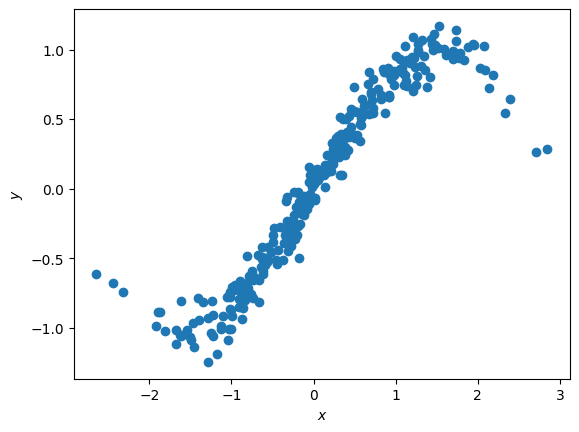

In [30]:
import matplotlib.pyplot as plt

N = 300
X = np.random.randn(N, 1)
y = np.sin(X) + 0.1*np.random.randn(N, 1)

plt.scatter(x=X, y=y)
plt.xlabel('$x$')
plt.ylabel('$y$')

X_mytensor = MyLeafTensor(X)
y_mytensor = MyLeafTensor(y)

In [31]:
input_features = 1
hidden_features = 100
output_features = 1

#We do a 2 layer network, as in Notebook 4.1
#Note that all the Parameters are MyLeafTensor's (mirroring how you need to use
#PyTorch tensors in PyTorch).
bias0 = MyLeafTensor(np.random.randn(hidden_features))
weights0 = MyLeafTensor(np.random.randn(input_features, hidden_features))
bias1 = MyLeafTensor(np.random.randn(output_features))
weights1 = MyLeafTensor(np.random.randn(hidden_features, output_features))

def net(input):
    """
    Applies our two-layer relu network to the input.
    """
    output_layer0 = relu(linear(input, weights0, bias0))
    output_layer1 =      linear(output_layer0, weights1, bias1)
    return output_layer1


In [32]:
#The training loop
learning_rate = 0.0001
for i in range(100):
    L = sqerr(y_mytensor, net(X_mytensor))
    if 0 == i % 10: #Print every 10th iteration
        print(L.value)
    L.backward(1)
    bias0.value    += -learning_rate*bias0.grad
    weights0.value += -learning_rate*weights0.grad
    bias1.value    += -learning_rate*bias1.grad
    weights1.value += -learning_rate*weights1.grad

    bias0.zero_grad()
    weights0.zero_grad()
    bias1.zero_grad()
    weights1.zero_grad()


37786.58594796769
1258.3640153807723
196.83901276978378
65.31666942608278
42.483506535503096
36.54396244805559
33.704555372927516
31.690955169504463
30.01469909170187
28.533936182684865


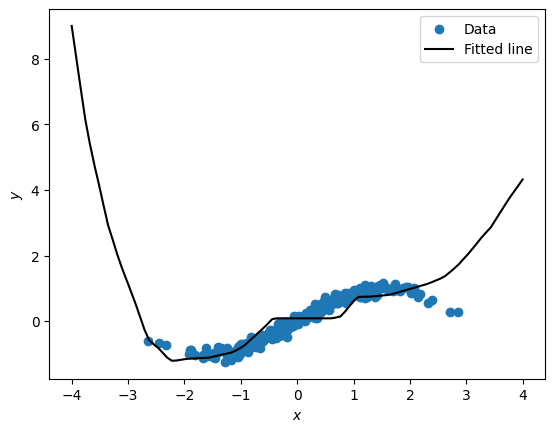

In [33]:
N = 300

xs = MyLeafTensor(np.linspace(-4, 4, 100)[:, None])
pred = net(xs)

plt.scatter(x=X, y=y, label='Data')
plt.plot(xs.value, pred.value, c='k', label='Fitted line')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()